# Useful code 

hopefully, this should contain some example code snippets to help you make maps and interactives

In [19]:
# Useful Libraries 
import pandas as pd
import intake 
import geopandas as gpd
import laplan
import intake_dcat 

import contextily
import matplotlib.pyplot as plt
import scipy.constants as constants


In [2]:
# Data Catalog 
catalog = intake.open_catalog('../catalog.yml')

## Make a map of LA zoning and transit lines 

This map will show all  areas with in a quater mile of a metro rail stop, as an example, that are zoned for R1 or other low densities

In [4]:
zoning = catalog.zoning.read()

In [6]:
# Filter the zoning data by zone classes which are low density 
low_density_zoning = zoning[
    zoning.ZONE_CLASS.isin(
        [
            'C1',
            'C1.5',
            'R1',
            'RD1.5',
            'RD2',
        ]
    )
]
low_density_zoning.head()

,OBJECTID,ZONE_CMPLT,ZONE_CLASS,ZONE_SMRY,SHAPE_Length,SHAPE_Area,geometry
22,23,(Q)C1.5-1,C1.5,COMMERCIAL,0.001151,7.920317e-08,"MULTIPOLYGON (((-118.57494 34.20903, -118.5749..."
23,24,(Q)C1.5-1,C1.5,COMMERCIAL,0.005080,9.174326e-07,"MULTIPOLYGON (((-118.56156 34.27577, -118.5611..."
24,25,(Q)C1.5-1,C1.5,COMMERCIAL,0.003634,2.849384e-07,"MULTIPOLYGON (((-118.60582 34.21877, -118.6058..."
25,26,(Q)C1.5-1L,C1.5,COMMERCIAL,0.003444,3.583232e-07,"MULTIPOLYGON (((-118.60526 34.22131, -118.6052..."
26,27,(Q)C1.5-1-RIO,C1.5,COMMERCIAL,0.001430,9.090309e-08,"MULTIPOLYGON (((-118.60670 34.19856, -118.6067..."


In [17]:
# load the metro rail network 
rail_stops = catalog.metro_rail_stations.read()

# buffer it and grab the areas 
FT_PER_MILE = 5280
elibigle_areas = rail_stops.to_crs('epsg:2229').buffer(FT_PER_MILE / 4)
elibigle_areas.head()

0    POLYGON ((6504350.095 1738033.828, 6504343.739...
1    POLYGON ((6504116.262 1739558.050, 6504109.906...
2    POLYGON ((6505434.567 1743039.068, 6505428.211...
3    POLYGON ((6505440.153 1745681.180, 6505433.797...
4    POLYGON ((6505315.170 1752228.119, 6505308.814...
dtype: geometry

In [ ]:
# intersect the selected zones 
union = low_density_zoning.buffer(0).unary_union

In [ ]:
type(union)

<AxesSubplot:>

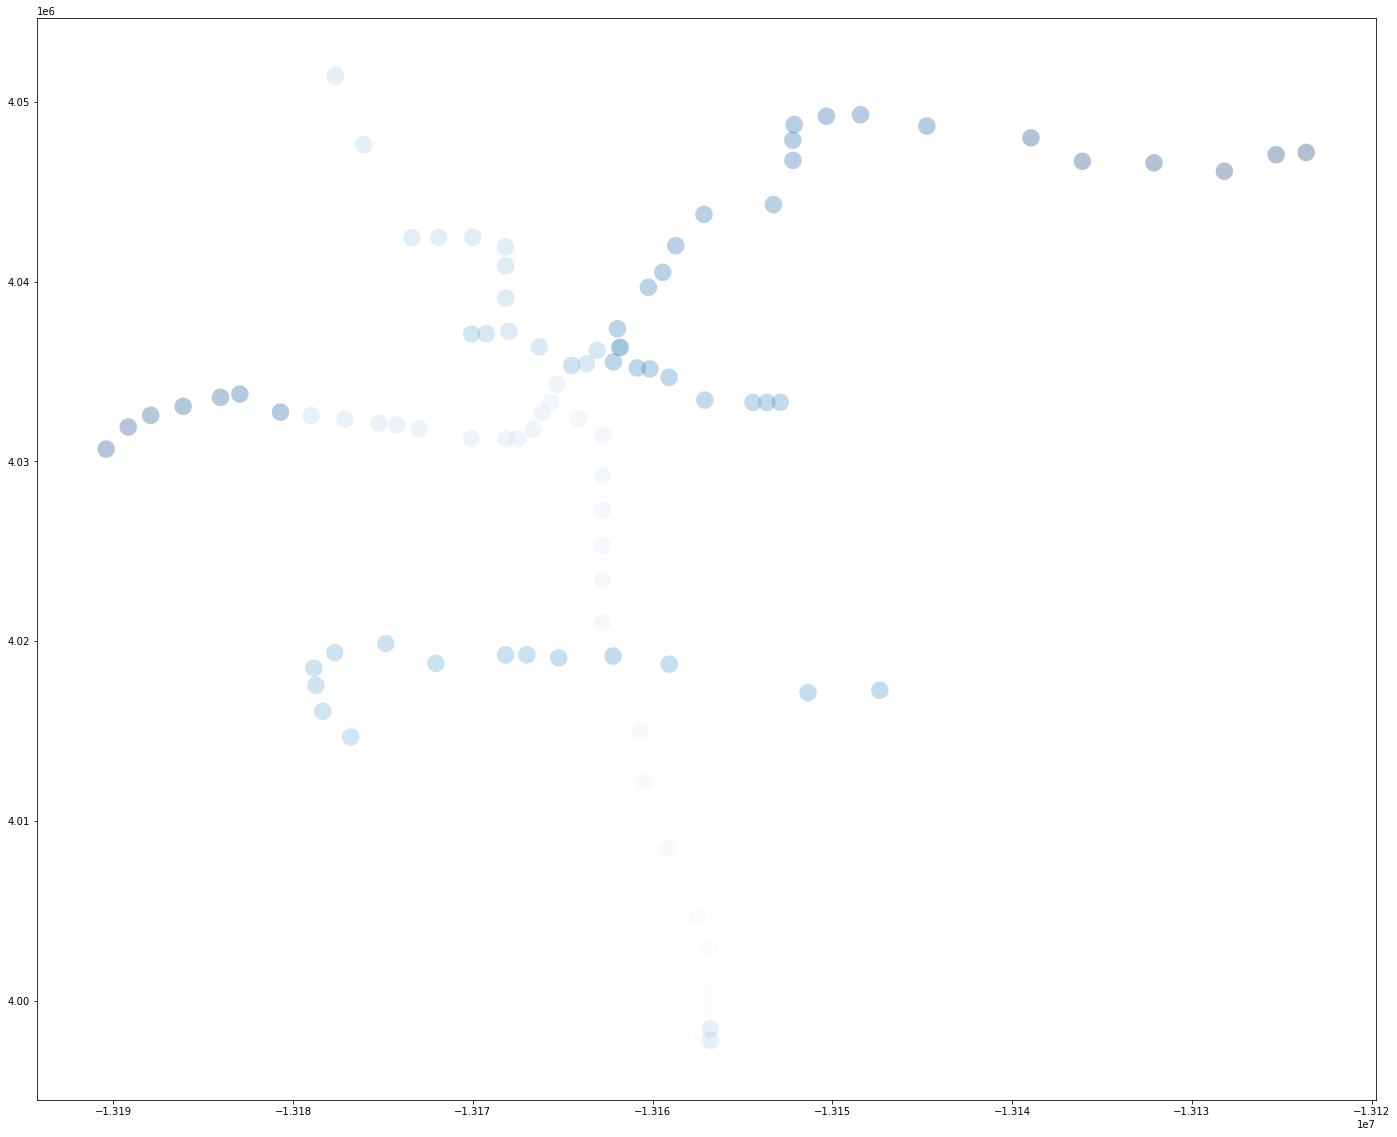

In [21]:

WEB_MERCATOR = 3857
fig, ax = plt.subplots(figsize=(24,24))
elibigle_areas.to_crs(epsg=WEB_MERCATOR).plot(alpha=0.3, cmap="Blues", ax=ax)
low_zoning_
contextily.add_basemap(ax, url=contextily.sources.ST_TONER_LITE)

## Interactive Sliders 

## Census Data Subsetting